In [1]:
import os
from os import getcwd
TRAIN = os.path.join(getcwd(), 'MinHash/data/articles_1000.train')
TRUTH = os.path.join(getcwd(), 'MinHash/data/articles_1000.truth')

In [2]:
import numpy as np
import string

In [3]:
def parse_data(filename):
    if not filename:
        raise ValueError("filename is empty.")
    
    with open(filename) as f:
        content = f.readlines()  # read lines from filename
        content = [x.strip() for x in content]
        exclude = set(string.punctuation)
        tuples = list()
        
    for line in content:
        id, article = line.split(" ", 1)
        article = ''.join(ch for ch in article if ch not in exclude).replace(' ', '').lower()
        tuples.append((id, article))  # construct tuple of id and text
        
    return tuples 

In [4]:
def shingle_document(string, k):
    if not string:
        raise ValueError("String is empty.")
    if not k:
        raise ValueError("k is empty.")
    
    import binascii
    
    unique_hash = set() # initialize set data structure
    for i in range(0, len(string) - k + 1):
        unique_hash.add(binascii.crc32(string[i:i+k].encode("utf-8"))) # has substring into 32-bit integer
        
    return unique_hash

In [5]:
def jaccard(a, b):
    if not a:
        raise ValueError("a is empty.")
    if not b:
        raise ValueError("b is empty.")
        
    a = set(a)
    b = set(b)

    return len(a.intersection(b))/len(a.union(b)) # return raio of union and intersection

In [6]:
def similarity(filename, k):
    if not filename:
        raise ValueError("filename is empty.")
    if not k:
        raise ValueError("k is empty.")
        
    tuples = parse_data(filename)  # parse a file with data
    tuples_js = list()

    n = len(tuples)

    for i in range(0, n - 1):
        id_i, article_i = tuples[i]
        
        if k > len(article_i):
            raise ValueError("k is out of bound.")

        for j in range(i + 1, n):
            id_j, article_j = tuples[j]
            
            if k > len(article_j):
                raise ValueError("k is out of bound.")

            s = jaccard(shingle_document(article_i, k), shingle_document(article_j, k))
            tuples_js.append((id_i, id_j, s))
            
    return tuples_js # return a list of tuples, each tuple contains: (id1, id2, s)

In [15]:
def get_mean_table(train, truth, n):
    
    if not train:
        raise ValueError("train data is empty.")
    if not truth:
        raise ValueError("truth data is empty.")
    if not n:
        raise ValueError("n is empty.")
    
    mytruth = parse_data(truth) # parse_data(), my truth is a pair of document ids   
    tuples  = list()
    
    for k in range(1, n + 1):
        
        js = similarity(train, k) # similarity
        abbr_dict = {tuple(item[0:2]): item[2] for item in js} # (id1, id2) is key, js is content.
        sum_train, sum_truth = 0, 0
        
        for j in range(0, len(mytruth)-1):
            sum_truth = abbr_dict[(mytruth[j])] + sum_truth # from dictionary we get js of key of (id1, id2)
            
        mean_truth = sum_truth/len(mytruth)
        
        for i in range(0, len(js)-1): 
            sum_train = js[i][2] + sum_train
            
        mean_train = (sum_train - sum_truth) / (len(js) - len(mytruth)) # (sum of train js - sum of truth js)/# of js
        tuples.append((k, mean_train, mean_truth))
        
    return tuples

In [8]:
def plot_mean_table(filename1, filename2, n):
    if not filename1:
        raise ValueError("filename1 is empty.")
    if not filename2:
        raise ValueError("filename2 is empty.")
    if not n:
        raise ValueError("n is empty.")
    
    import matplotlib.pyplot as plt
    import pandas as pd
    
    mean_table = get_mean_table(filename1, filename2, n)
    df         = pd.DataFrame(mean_table)
    df.columns = ["k", "non-plagiarism instances", "plagiarism instances"]
    
    plt.plot('k', 'non-plagiarism instances', data = df, color = 'green')
    plt.plot('k', 'plagiarism instances',     data = df, color = 'red')
    
    plt.xlabel('k value')
    plt.ylabel('average Jaccard similarity')
    
    plt.title('Plagiarism and Non-Plagiarism Articles\'\nJaccard Similarity Comparison\n')
    plt.legend()
    plt.show()
    
    pass

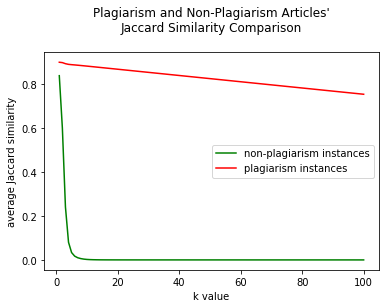

In [17]:
plot_mean_table(TRAIN, TRUTH, 100)

#### What is the effect of sharding length k on the Jaccard similarity of plagiarism instances versus instances that are not plagiarized?

### My thoughts:
#### 1. The effect of sharding length k on the Jaccard similarity of plagiarism instantces is far less stronger than that on the Jaccard similarity of non-plagiarism instance. ######

#### 2. Jaccard similarity of non-plagiarism instances increases dramatically when the length k is sharded from a small value to a smaller one, while that of plagiarism instances doesn't change much within the scope of length k.